In [9]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym

SEED = 42
rng = np.random.default_rng(SEED)

In [10]:
env_id = "FrozenLake-v1"
env_kwargs = {"is_slippery": False}
env = gym.make(env_id, **env_kwargs)
state, info = env.reset(seed=SEED)

n_states = env.observation_space.n
n_actions = env.action_space.n

print(f"Environment: {env_id}")
print(f"States: {n_states}, Actions: {n_actions}")
print("Initial observation:", state)

Environment: FrozenLake-v1
States: 16, Actions: 4
Initial observation: 0


## Q-learning setup
We train a tabular Q-learning agent with an epsilon-greedy exploration schedule, tracking per-episode rewards and success rates.

In [11]:
episodes = 5000
max_steps = 100
alpha = 0.8
gamma = 0.95
epsilon_start, epsilon_end, epsilon_decay = 1.0, 0.05, 0.995

q_table = np.zeros((n_states, n_actions))
epsilon = epsilon_start
episode_rewards = []
success_flags = []

for episode in range(episodes):
    state, _ = env.reset(seed=SEED + episode)
    total_reward = 0.0
    success = 0

    for step in range(max_steps):
        if rng.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = int(np.argmax(q_table[state]))

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        best_next = np.max(q_table[next_state])
        td_target = reward + gamma * best_next * (1 - done)
        q_table[state, action] += alpha * (td_target - q_table[state, action])

        total_reward += reward
        state = next_state

        if done:
            success = 1 if reward > 0 else 0
            break

    episode_rewards.append(total_reward)
    success_flags.append(success)
    epsilon = max(epsilon_end, epsilon * epsilon_decay)

print(f"Training complete. Final epsilon: {epsilon:.3f}")

Training complete. Final epsilon: 0.050


## Training diagnostics
Rolling success rate and reward distributions help verify the policy converges.

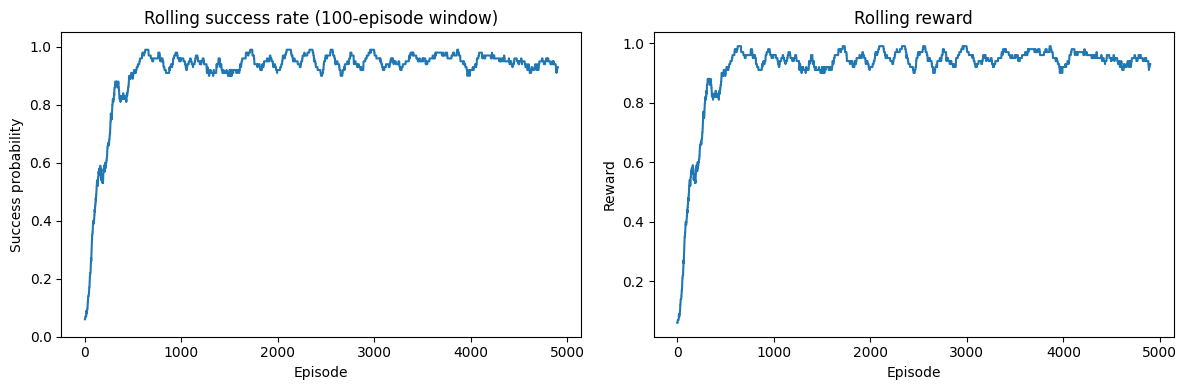

In [12]:
window = min(100, len(success_flags))
if window > 0:
    kernel = np.ones(window) / window
    rolling_success = np.convolve(success_flags, kernel, mode="valid")
    rolling_rewards = np.convolve(episode_rewards, kernel, mode="valid")

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].plot(rolling_success)
    axes[0].set_title(f"Rolling success rate ({window}-episode window)")
    axes[0].set_ylim(0, 1.05)
    axes[0].set_ylabel("Success probability")
    axes[0].set_xlabel("Episode")

    axes[1].plot(rolling_rewards)
    axes[1].set_title("Rolling reward")
    axes[1].set_ylabel("Reward")
    axes[1].set_xlabel("Episode")

    plt.tight_layout()
else:
    print("No training data to plot.")

## Policy evaluation
Run a handful of greedy rollouts and optionally render the grid to check the learned policy.

In [15]:
def run_greedy_episode(render=False, seed_offset=0):
    eval_env = gym.make(env_id, render_mode="human" if render else None, **env_kwargs)
    state, _ = eval_env.reset(seed=SEED + seed_offset)
    frames = []
    total_reward = 0.0
    done = False

    while not done:
        action = int(np.argmax(q_table[state]))
        next_state, reward, terminated, truncated, _ = eval_env.step(action)
        if render:
            frames.append(eval_env.render())
        total_reward += reward
        state = next_state
        done = terminated or truncated

    eval_env.close()
    return total_reward, frames

num_eval_episodes = 5
eval_rewards = []
for idx in range(num_eval_episodes):
    reward, _ = run_greedy_episode(render=False, seed_offset=100 + idx)
    eval_rewards.append(reward)

print(f"Average greedy reward over {num_eval_episodes} episodes: {np.mean(eval_rewards):.2f}")
print("Successful runs:", sum(eval_rewards))

_, frames = run_greedy_episode(render=True, seed_offset=200)
print("\nSample rendered trajectory:")
for step, frame in enumerate(frames):
    print(f"Step {step}\n{frame}")

Average greedy reward over 5 episodes: 1.00
Successful runs: 5.0

Sample rendered trajectory:
Step 0
None
Step 1
None
Step 2
None
Step 3
None
Step 4
None
Step 5
None


In [14]:
env.close()